In [384]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook

import warnings

In [2]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 1000)

pd.options.display.float_format = '{:.4f}'.format

warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv(r'C:\Users\79175\Desktop\BGI Group Recruiting/E14.5_E1S3_Dorsal_Midbrain_GEM_CellBin_merge.tsv',
                delimiter = '\t')

# Exploratory Data Analysis

In [4]:
# Looking at the structure of the data set

df.head()

geneID      x     y  MIDCounts    cell
0         Arpc1b  19881  9379          3  170675
1  B230118H07Rik  19881  9379          2  170675
2        Bcl2l12  19881  9379          1  170675
3          Ccnd3  19881  9379          1  170675
4           Cdk8  19881  9379          3  170675

### Information provided by BGI

geneID - Name of the gene <br>
x - x-coordinate of the cell <br>
y - y-coordinate of the cell <br>
MIDCounts - count number of gene expression <br>
cell - cell id <br>
If rows have the same cell_id that means that these genes are expressed in the same cell correspoding to this sprecific cell_id<br>
Each Gene may express in more than one cell, and a Cell contains more than one expressed Gene.<br>

In [5]:
# Looking at some aspects of the dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1656407 entries, 0 to 1656406
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   geneID     1656407 non-null  object
 1   x          1656407 non-null  int64 
 2   y          1656407 non-null  int64 
 3   MIDCounts  1656407 non-null  int64 
 4   cell       1656407 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 63.2+ MB


In [6]:
# how many unique cells are included in the data set

len(df['cell'].unique())

4872

In [7]:
# how many unique genes are included in the data set

len(df['geneID'].unique())

18698

# Checking the distributions of x and y coordinates and outliers

## Analysing x

<AxesSubplot:xlabel='x'>

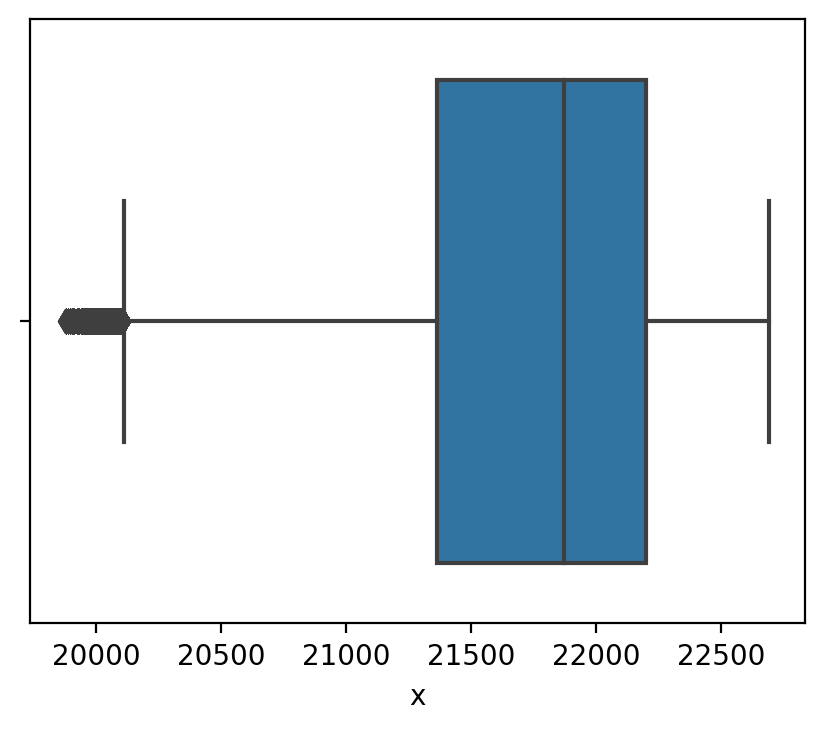

In [8]:
plt.figure(figsize = (5,4), dpi = 200)

sns.boxplot(df['x'])

In [9]:
# calculating the quartile information to see how many points are considered "outliers" by the box plot

q3, q1 = np.percentile(df['x'], [75 ,25])

iqr = q3 - q1

len(df[df['x'] < q1 - iqr*1.5])

47790

There are "outliers" in x, however, this might be the nature of the data set 

## Analysing y

<AxesSubplot:xlabel='y'>

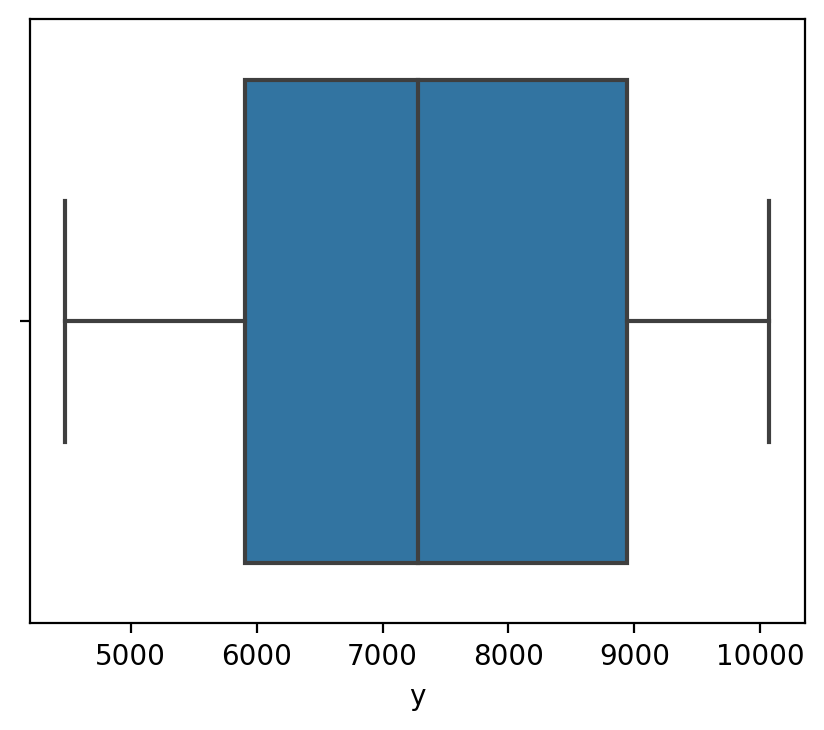

In [10]:
plt.figure(figsize = (5,4), dpi = 200)

sns.boxplot(df['y'])

There are no outliers in y

## Checking if there is a connection between the position of a cell and its ID

In [11]:
# maximum value of cell_id for the outliers (in regards to 'x')
df[df['x'] < q1 - iqr*1.5]['cell'].max()

172532

In [12]:
# minimum value of cell_id for the cells that are NOT outliers (in regards to 'x')

df[df['cell'].isin(df[df['x'] < q1 - iqr*1.5]['cell'].unique()) == False]['cell'].min()

172517

It seems like the 'cell' column is based on the x-coordinate of the cell. Can be confirmed by checking the correlation between 'x' and 'cell'

In [13]:
# checking correlation between 'x' and 'cell' columns

df[['cell', 'x']].corr()

cell      x
cell 1.0000 0.9939
x    0.9939 1.0000

As expected, 'cell' (cell ID) is based on the position of the cell along the x-axis

# Algorithm Development

Spatial clustering algothim aimed at predicting the clusters of tissues in dorsal midbrain of a mouse will be developed in this and following sections. The algorithm will be based on the cell location and its gene composition.<br> <br>

The data presented contains information about: <br>
    1. Position of the cell in 2-dimensional plane (x-y plane) <br>
    2. Gene composition of the cell (18 698 unique gene names found in the data set) <br> <br>

Based on this data an algorithm for spatial tissue clustering will be developed. However, the data set presented has to be reformatted as follows:<br>
    1. Each row must correspond to a specific cell in mouse's midbrain.<br>
    2. Features will include x-coordinate, y-coordinate and the information about genes.<br><br>
   
At this point there 18 700 features (x, y, 18 698 unique genes) are available to be included in the final dataset, however, it is unreasonable to include that many features. Therefore, it is logical to include top 20-50 most widespread genes and use them in conjunction with 2d-location of a cell to cluster cells together. Furthermore, Principle Component Analysis will be carried out in order to decrease the number of features even more and, hence, if possible reduce the computational time required in order for the spatial clustering algorithm to run. <br><br> 
#### Structure of the development process
1. Restructuring the data set in order to bring the data set to the state described above. 
2. Principle Component Analysis.
3. The algorithm assembly and performance assessment.

## Section 1: Restructuring the data set
The data set should be restructured as follows:
1. Each row must correspond to a specific cell in mouse's midbrain.
2. Columns will include: position of the cell in 2D-plane, gene composition of the cell.


In [14]:
# Current structure of the data set
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1656407 entries, 0 to 1656406
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   geneID     1656407 non-null  object
 1   x          1656407 non-null  int64 
 2   y          1656407 non-null  int64 
 3   MIDCounts  1656407 non-null  int64 
 4   cell       1656407 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 63.2+ MB


In [15]:
columns_for_final_df = ['x', 'y']


for i in df['geneID'].unique():
    columns_for_final_df.append(i)

In [16]:
final_df = pd.DataFrame(columns = columns_for_final_df, index = df['cell'].unique())
final_df

x    y Arpc1b B230118H07Rik Bcl2l12 Ccnd3 Cdk8 Commd4 Cops9 Creg1  \
170675  NaN  NaN    NaN           NaN     NaN   NaN  NaN    NaN   NaN   NaN   
170785  NaN  NaN    NaN           NaN     NaN   NaN  NaN    NaN   NaN   NaN   
170808  NaN  NaN    NaN           NaN     NaN   NaN  NaN    NaN   NaN   NaN   
170818  NaN  NaN    NaN           NaN     NaN   NaN  NaN    NaN   NaN   NaN   
170819  NaN  NaN    NaN           NaN     NaN   NaN  NaN    NaN   NaN   NaN   
...     ...  ...    ...           ...     ...   ...  ...    ...   ...   ...   
181840  NaN  NaN    NaN           NaN     NaN   NaN  NaN    NaN   NaN   NaN   
181841  NaN  NaN    NaN           NaN     NaN   NaN  NaN    NaN   NaN   NaN   
181842  NaN  NaN    NaN           NaN     NaN   NaN  NaN    NaN   NaN   NaN   
181843  NaN  NaN    NaN           NaN     NaN   NaN  NaN    NaN   NaN   NaN   
181844  NaN  NaN    NaN           NaN     NaN   NaN  NaN    NaN   NaN   NaN   

       Dhx36 Emc7 Emg1 Fam111a Fbrs Fbxl12 Ftl1 Fundc2 Galnt10  Gls Gm10076  \
170675   NaN  NaN  NaN     NaN  NaN    NaN  NaN    NaN     NaN  NaN     NaN   
170785   NaN  NaN  NaN     NaN  NaN    NaN  NaN    NaN     NaN  NaN     NaN   
170808   NaN  NaN  NaN     NaN  NaN    NaN  NaN    NaN     NaN  NaN     NaN   
170818   NaN  NaN  NaN     NaN  NaN    NaN  NaN    NaN     NaN  NaN     NaN   
170819   NaN  NaN  NaN     NaN  NaN    NaN  NaN    NaN     NaN  NaN     NaN   
...      ...  ...  ...     ...  ...    ...  ...    ...     ...  ...     ...   
181840   NaN  NaN  NaN     NaN  NaN    NaN  NaN    NaN     NaN  NaN     NaN   
181841   NaN  NaN  NaN     NaN  NaN    NaN  NaN    NaN     NaN  NaN     NaN   
181842   NaN  NaN  NaN     NaN  NaN    NaN  NaN    NaN     NaN  NaN     NaN   
181843   NaN  NaN  NaN     NaN  NaN    NaN  NaN    NaN     NaN  NaN     NaN   
181844   NaN  NaN  NaN     NaN  NaN    NaN  NaN    NaN     NaN  NaN     NaN   

       Gm15976 Gm2000 Gm20425 Gm42418 Gpx7 H1f0 H2afv H2afy Hba-x Hbb-bt  \
170675     NaN    NaN     NaN     NaN  NaN  NaN   NaN   NaN   NaN    NaN   
170785     NaN    NaN     NaN     NaN  NaN  NaN   NaN   NaN   NaN    NaN   
170808     NaN    NaN     NaN     NaN  NaN  NaN   NaN   NaN   NaN    NaN   
170818     NaN    NaN     NaN     NaN  NaN  NaN   NaN   NaN   NaN    NaN   
170819     NaN    NaN     NaN     NaN  NaN  NaN   NaN   NaN   NaN    NaN   
...        ...    ...     ...     ...  ...  ...   ...   ...   ...    ...   
181840     NaN    NaN     NaN     NaN  NaN  NaN   NaN   NaN   NaN    NaN   
181841     NaN    NaN     NaN     NaN  NaN  NaN   NaN   NaN   NaN    NaN   
181842     NaN    NaN     NaN     NaN  NaN  NaN   NaN   NaN   NaN    NaN   
181843     NaN    NaN     NaN     NaN  NaN  NaN   NaN   NaN   NaN    NaN   
181844     NaN    NaN     NaN     NaN  NaN  NaN   NaN   NaN   NaN    NaN   

       Higd2a Hnrnpab Igf1r Jarid2 Kars Klf2 Lgals1 Mcm7 Med10 Mrps26  Msn  \
170675    NaN     NaN   NaN    NaN  NaN  NaN    NaN  NaN   NaN    NaN  NaN   
170785    NaN     NaN   NaN    NaN  NaN  NaN    NaN  NaN   NaN    NaN  NaN   
170808    NaN     NaN   NaN    NaN  NaN  NaN    NaN  NaN   NaN    NaN  NaN   
170818    NaN     NaN   NaN    NaN  NaN  NaN    NaN  NaN   NaN    NaN  NaN   
170819    NaN     NaN   NaN    NaN  NaN  NaN    NaN  NaN   NaN    NaN  NaN   
...       ...     ...   ...    ...  ...  ...    ...  ...   ...    ...  ...   
181840    NaN     NaN   NaN    NaN  NaN  NaN    NaN  NaN   NaN    NaN  NaN   
181841    NaN     NaN   NaN    NaN  NaN  NaN    NaN  NaN   NaN    NaN  NaN   
181842    NaN     NaN   NaN    NaN  NaN  NaN    NaN  NaN   NaN    NaN  NaN   
181843    NaN     NaN   NaN    NaN  NaN  NaN    NaN  NaN   NaN    NaN  NaN   
181844    NaN     NaN   NaN    NaN  NaN  NaN    NaN  NaN   NaN    NaN  NaN   

       Myh9 Naaladl2 Ndufa13 Ndufa3 Nr2c2ap Ntan1 Oard1 Paf1 Pebp1 Pigp  \
170675  NaN      NaN     NaN    NaN     NaN   NaN   NaN  NaN   NaN  NaN   
170785  NaN      NaN     NaN    NaN     NaN   NaN   NaN  NaN   NaN  NaN   
170808  NaN      NaN     NaN    NaN  

In [17]:
# filling in 'x' and 'y' columns

for i in final_df.index:
    final_df['x'].loc[i] = df[df['cell'] == i]['x'].mean()
    final_df['y'].loc[i] = df[df['cell'] == i]['y'].mean()
final_df

x         y Arpc1b B230118H07Rik Bcl2l12 Ccnd3 Cdk8 Commd4  \
170675 19881.0000 9379.0000    NaN           NaN     NaN   NaN  NaN    NaN   
170785 19875.0000 9350.0000    NaN           NaN     NaN   NaN  NaN    NaN   
170808 19886.0000 9330.0000    NaN           NaN     NaN   NaN  NaN    NaN   
170818 19904.0000 9160.0000    NaN           NaN     NaN   NaN  NaN    NaN   
170819 19902.0000 9216.0000    NaN           NaN     NaN   NaN  NaN    NaN   
...           ...       ...    ...           ...     ...   ...  ...    ...   
181840 22663.0000 6831.0000    NaN           NaN     NaN   NaN  NaN    NaN   
181841 22654.0000 6877.0000    NaN           NaN     NaN   NaN  NaN    NaN   
181842 22666.0000 6906.0000    NaN           NaN     NaN   NaN  NaN    NaN   
181843 22668.0000 6560.0000    NaN           NaN     NaN   NaN  NaN    NaN   
181844 22695.0000 6346.0000    NaN           NaN     NaN   NaN  NaN    NaN   

       Cops9 Creg1 Dhx36 Emc7 Emg1 Fam111a Fbrs Fbxl12 Ftl1 Fundc2 Galnt10  \
170675   NaN   NaN   NaN  NaN  NaN     NaN  NaN    NaN  NaN    NaN     NaN   
170785   NaN   NaN   NaN  NaN  NaN     NaN  NaN    NaN  NaN    NaN     NaN   
170808   NaN   NaN   NaN  NaN  NaN     NaN  NaN    NaN  NaN    NaN     NaN   
170818   NaN   NaN   NaN  NaN  NaN     NaN  NaN    NaN  NaN    NaN     NaN   
170819   NaN   NaN   NaN  NaN  NaN     NaN  NaN    NaN  NaN    NaN     NaN   
...      ...   ...   ...  ...  ...     ...  ...    ...  ...    ...     ...   
181840   NaN   NaN   NaN  NaN  NaN     NaN  NaN    NaN  NaN    NaN     NaN   
181841   NaN   NaN   NaN  NaN  NaN     NaN  NaN    NaN  NaN    NaN     NaN   
181842   NaN   NaN   NaN  NaN  NaN     NaN  NaN    NaN  NaN    NaN     NaN   
181843   NaN   NaN   NaN  NaN  NaN     NaN  NaN    NaN  NaN    NaN     NaN   
181844   NaN   NaN   NaN  NaN  NaN     NaN  NaN    NaN  NaN    NaN     NaN   

        Gls Gm10076 Gm15976 Gm2000 Gm20425 Gm42418 Gpx7 H1f0 H2afv H2afy  \
170675  NaN     NaN     NaN    NaN     NaN     NaN  NaN  NaN   NaN   NaN   
170785  NaN     NaN     NaN    NaN     NaN     NaN  NaN  NaN   NaN   NaN   
170808  NaN     NaN     NaN    NaN     NaN     NaN  NaN  NaN   NaN   NaN   
170818  NaN     NaN     NaN    NaN     NaN     NaN  NaN  NaN   NaN   NaN   
170819  NaN     NaN     NaN    NaN     NaN     NaN  NaN  NaN   NaN   NaN   
...     ...     ...     ...    ...     ...     ...  ...  ...   ...   ...   
181840  NaN     NaN     NaN    NaN     NaN     NaN  NaN  NaN   NaN   NaN   
181841  NaN     NaN     NaN    NaN     NaN     NaN  NaN  NaN   NaN   NaN   
181842  NaN     NaN     NaN    NaN     NaN     NaN  NaN  NaN   NaN   NaN   
181843  NaN     NaN     NaN    NaN     NaN     NaN  NaN  NaN   NaN   NaN   
181844  NaN     NaN     NaN    NaN     NaN     NaN  NaN  NaN   NaN   NaN   

       Hba-x Hbb-bt Higd2a Hnrnpab Igf1r Jarid2 Kars Klf2 Lgals1 Mcm7 Med10  \
170675   NaN    NaN    NaN     NaN   NaN    NaN  NaN  NaN    NaN  NaN   NaN   
170785   NaN    NaN    NaN     NaN   NaN    NaN  NaN  NaN    NaN  NaN   NaN   
170808   NaN    NaN    NaN     NaN   NaN    NaN  NaN  NaN    NaN  NaN   NaN   
170818   NaN    NaN    NaN     NaN   NaN    NaN  NaN  NaN    NaN  NaN   NaN   
170819   NaN    NaN    NaN     NaN   NaN    NaN  NaN  NaN    NaN  NaN   NaN   
...      ...    ...    ...     ...   ...    ...  ...  ...    ...  ...   ...   
181840   NaN    NaN    NaN     NaN   NaN    NaN  NaN  NaN    NaN  NaN   NaN   
181841   NaN    NaN    NaN     NaN   NaN    NaN  NaN  NaN    NaN  NaN   NaN   
181842   NaN    NaN    NaN     NaN   NaN    NaN  NaN  NaN    NaN  NaN   NaN   
181843   NaN    NaN    NaN     NaN   NaN    NaN  NaN  NaN    NaN  NaN   NaN   
181844   NaN    NaN    NaN     NaN   NaN    NaN  NaN  NaN    NaN  NaN   NaN   

       Mrps26  Msn Myh9 Naaladl2 Ndufa13 Ndufa3 Nr2c2ap Ntan1 Oard1 Paf1  \
170675    NaN  NaN  NaN      NaN     NaN    NaN     NaN   NaN   NaN  NaN   
170785    NaN  NaN  NaN      NaN     NaN    NaN     NaN   NaN   NaN  NaN   
170808    NaN  NaN  NaN      NaN     NaN    NaN     

In [18]:
# for i in final_df.index:
#     for col in final_df.columns:
#         if col in (df_copy[df_copy['cell'] == i]['geneID'].tolist()):
#             final_df[col].loc[i] = df_copy[(df_copy['cell'] == i) & (df_copy['geneID'] == col)]['MIDCounts']
#         elif (col == 'x') or (col == 'y'):
#             pass
#         else:
#             final_df[col].loc[i] = 0

# final_df

## Trying KMeans and DBSCAN on a dataset containing only positional features

### KMeans Model with only 2 positional features

In [19]:
final_df = final_df[['x', 'y']]

In [20]:
final_df

x         y
170675 19881.0000 9379.0000
170785 19875.0000 9350.0000
170808 19886.0000 9330.0000
170818 19904.0000 9160.0000
170819 19902.0000 9216.0000
...           ...       ...
181840 22663.0000 6831.0000
181841 22654.0000 6877.0000
181842 22666.0000 6906.0000
181843 22668.0000 6560.0000
181844 22695.0000 6346.0000

[4872 rows x 2 columns]

In [21]:
from sklearn.preprocessing import StandardScaler

In [22]:
scaler = StandardScaler()

In [23]:
X_scaled = scaler.fit_transform(final_df)

In [24]:
from sklearn.cluster import KMeans

In [25]:
kmeans_model = KMeans(n_clusters = 11)

In [26]:
kmeans_model.fit_predict(X_scaled)

array([3, 3, 3, ..., 7, 7, 7])

<AxesSubplot:xlabel='x', ylabel='y'>

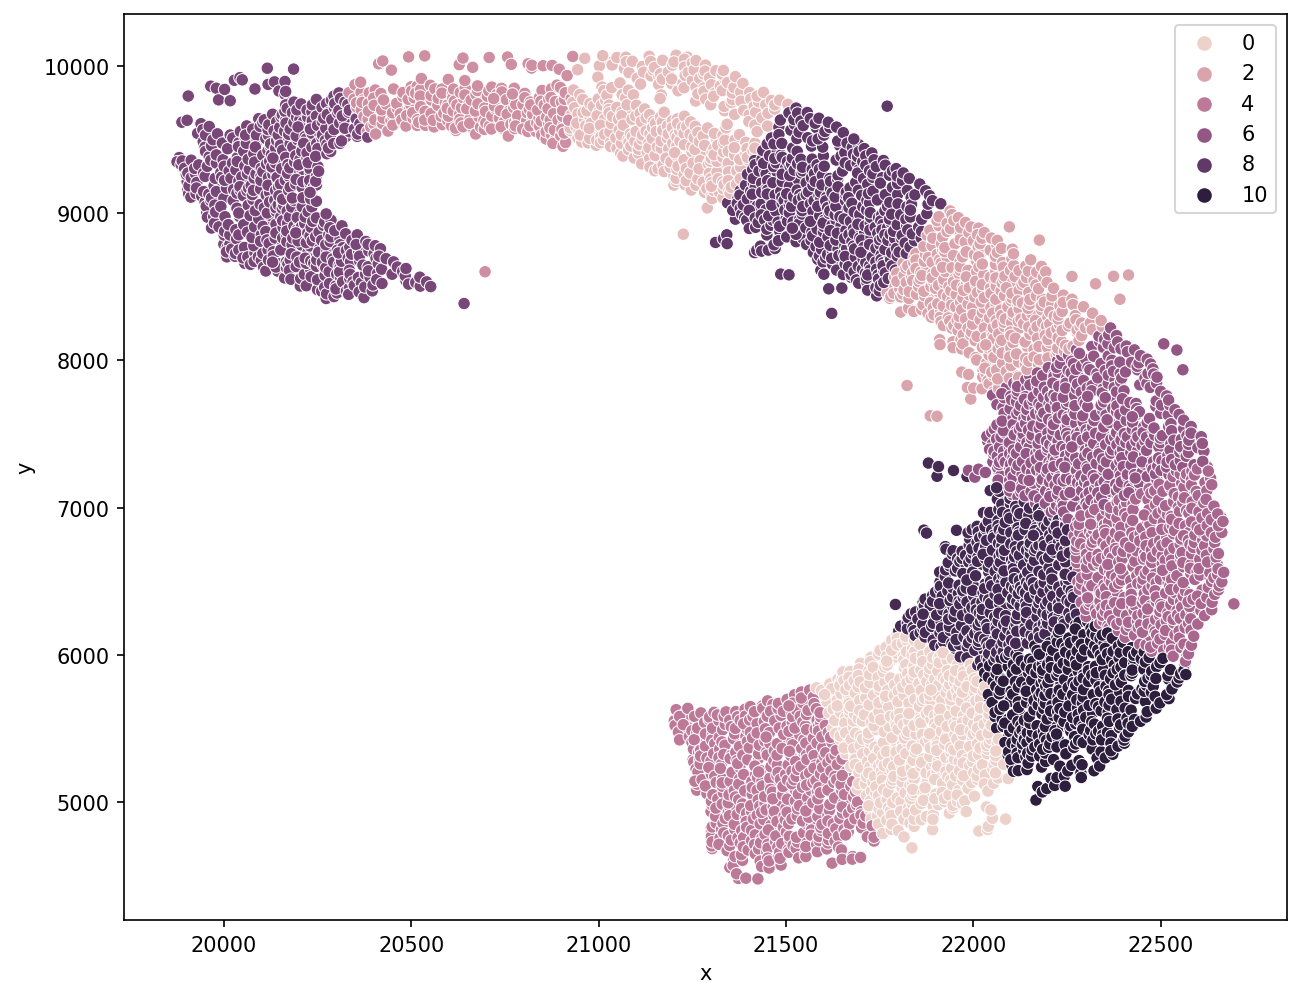

In [27]:
plt.figure(figsize = (10,8), dpi = 150)

sns.scatterplot(final_df['x'], final_df['y'], hue = kmeans_model.fit_predict(X_scaled))

### DBSCAN Model with only 2 positional features

In [28]:
from sklearn.cluster import DBSCAN

In [29]:
n_clusters = []

for i in np.linspace(0.00001, 2, 41):
    db_model = DBSCAN(eps = i)
    db_model.fit(X_scaled)
    
    n_clusters.append(len(pd.Series(db_model.labels_).unique()))
    

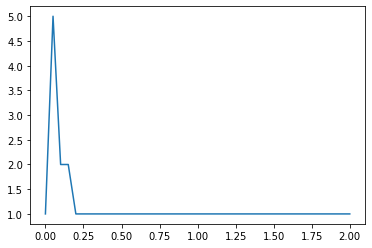

In [30]:
plt.plot(np.linspace(0.00001, 2, 41), n_clusters)

In [31]:
db_model = DBSCAN(eps = np.linspace(0.00001, 2, 41)[1])

<AxesSubplot:xlabel='x', ylabel='y'>

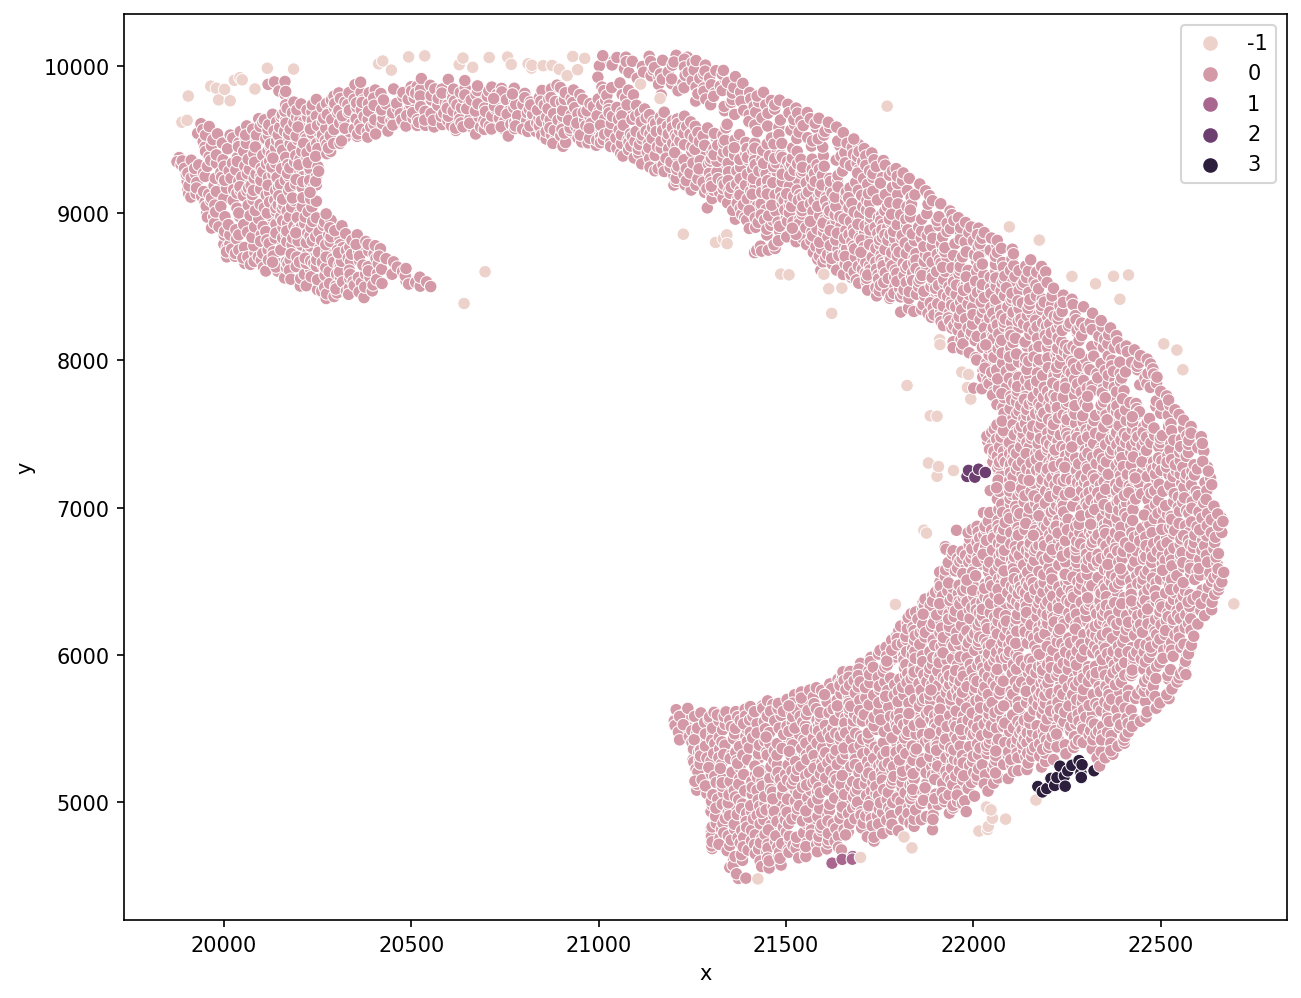

In [32]:
plt.figure(figsize = (10,8), dpi = 150)

sns.scatterplot(final_df['x'], final_df['y'], hue = db_model.fit_predict(X_scaled))

Running clustering algorithm on the data set consisting of positional features did not yield any results as exprected<br>
Now new features containing information about the genes will be added to the data set.

## Adding gene based features to the data set

There are ~ 19 000 unique genes in the initial data set each of which can be used as a potential feature, however, including 19 000 would make the data set improportional. It would be virtually impossible to run classification on this kind of a data set. <br>
It is reasonable to select only some of the available genes to be in the new data set. <br>
Approach below is based on the abundancy of a specific gene in the mid brain. First, 25 most abundant genes will be added to the data set. If the classifications algorithms fail to pick up the necessary signal more genes will be considered.

In [60]:
# Exctract 25 most abundant genes from the initial data set and set them as features in the new data set.

columns_for_50_genes = ['x', 'y']


for i in df[['geneID', 'MIDCounts']].groupby('geneID').sum().sort_values(by = 'MIDCounts', ascending = False).head(25).index:
    columns_for_50_genes.append(i)

columns_for_50_genes

['x',
 'y',
 'Gm42418',
 'Cdk8',
 'Tmsb4x',
 'Hbb-bs',
 'Tuba1a',
 'Rpl41',
 'Gphn',
 'Malat1',
 'Ftl1',
 'Hba-a1',
 'Lars2',
 'Cmss1',
 'Rplp0',
 'Actb',
 'Rps14',
 'Tubb5',
 'Rps5',
 'Hba-a2',
 'Rps8',
 'Hbb-bt',
 'Rps26',
 'Rpl37a',
 'Rplp1',
 'Rps19',
 'Hsp90ab1']

In [61]:
# Creation of the new data set which will be used for clustering

final_df_with_50_genes = pd.DataFrame(columns = columns_for_50_genes, index = df['cell'].unique())
final_df_with_50_genes.head()

x    y Gm42418 Cdk8 Tmsb4x Hbb-bs Tuba1a Rpl41 Gphn Malat1 Ftl1  \
170675  NaN  NaN     NaN  NaN    NaN    NaN    NaN   NaN  NaN    NaN  NaN   
170785  NaN  NaN     NaN  NaN    NaN    NaN    NaN   NaN  NaN    NaN  NaN   
170808  NaN  NaN     NaN  NaN    NaN    NaN    NaN   NaN  NaN    NaN  NaN   
170818  NaN  NaN     NaN  NaN    NaN    NaN    NaN   NaN  NaN    NaN  NaN   
170819  NaN  NaN     NaN  NaN    NaN    NaN    NaN   NaN  NaN    NaN  NaN   

       Hba-a1 Lars2 Cmss1 Rplp0 Actb Rps14 Tubb5 Rps5 Hba-a2 Rps8 Hbb-bt  \
170675    NaN   NaN   NaN   NaN  NaN   NaN   NaN  NaN    NaN  NaN    NaN   
170785    NaN   NaN   NaN   NaN  NaN   NaN   NaN  NaN    NaN  NaN    NaN   
170808    NaN   NaN   NaN   NaN  NaN   NaN   NaN  NaN    NaN  NaN    NaN   
170818    NaN   NaN   NaN   NaN  NaN   NaN   NaN  NaN    NaN  NaN    NaN   
170819    NaN   NaN   NaN   NaN  NaN   NaN   NaN  NaN    NaN  NaN    NaN   

       Rps26 Rpl37a Rplp1 Rps19 Hsp90ab1  
170675   NaN    NaN   NaN   NaN      NaN  
170785   NaN    NaN   NaN   NaN      NaN  
170808   NaN    NaN   NaN   NaN      NaN  
170818   NaN    NaN   NaN   NaN      NaN  
170819   NaN    NaN   NaN   NaN      NaN

In [62]:
# mean x and y coordinates of each cell are extracted from the initial data set. Mean values are taken to solve the problem
# of one cell being represented by several coordinates due to its size. This format would not be suited for the problem at
# hand, therefore, the decision of taking the mean.

final_df_with_50_genes['x'] = final_df['x']
final_df_with_50_genes['y'] = final_df['y']
final_df_with_50_genes.head()

x         y Gm42418 Cdk8 Tmsb4x Hbb-bs Tuba1a Rpl41 Gphn  \
170675 19881.0000 9379.0000     NaN  NaN    NaN    NaN    NaN   NaN  NaN   
170785 19875.0000 9350.0000     NaN  NaN    NaN    NaN    NaN   NaN  NaN   
170808 19886.0000 9330.0000     NaN  NaN    NaN    NaN    NaN   NaN  NaN   
170818 19904.0000 9160.0000     NaN  NaN    NaN    NaN    NaN   NaN  NaN   
170819 19902.0000 9216.0000     NaN  NaN    NaN    NaN    NaN   NaN  NaN   

       Malat1 Ftl1 Hba-a1 Lars2 Cmss1 Rplp0 Actb Rps14 Tubb5 Rps5 Hba-a2 Rps8  \
170675    NaN  NaN    NaN   NaN   NaN   NaN  NaN   NaN   NaN  NaN    NaN  NaN   
170785    NaN  NaN    NaN   NaN   NaN   NaN  NaN   NaN   NaN  NaN    NaN  NaN   
170808    NaN  NaN    NaN   NaN   NaN   NaN  NaN   NaN   NaN  NaN    NaN  NaN   
170818    NaN  NaN    NaN   NaN   NaN   NaN  NaN   NaN   NaN  NaN    NaN  NaN   
170819    NaN  NaN    NaN   NaN   NaN   NaN  NaN   NaN   NaN  NaN    NaN  NaN   

       Hbb-bt Rps26 Rpl37a Rplp1 Rps19 Hsp90ab1  
170675    NaN   NaN    NaN   NaN   NaN      NaN  
170785    NaN   NaN    NaN   NaN   NaN      NaN  
170808    NaN   NaN    NaN   NaN   NaN      NaN  
170818    NaN   NaN    NaN   NaN   NaN      NaN  
170819    NaN   NaN    NaN   NaN   NaN      NaN

In order to fill the the feature values for the cells a nested "for" loop is required. It is computationally heavy. In order to reduce the time it will take to compute, the initial data set is first reduced to contain only 25 most abundant genes.

In [63]:
# df_25 is a slice of the original data set, but with "geneID" filtered to contain only 25 most abundant genes

df_10 = df[df['geneID'].isin(df[['geneID', 'MIDCounts']].groupby('geneID').sum().sort_values(by = 'MIDCounts', ascending = False).head(25).index)]

In [64]:
# Filling in feature values based on the initial data set

for col in final_df_with_50_genes.columns:
    for i in final_df_with_50_genes.index:
        if col in (df_10[df_10['cell'] == i]['geneID'].tolist()):
            final_df_with_50_genes[col].loc[i] = df_10[(df_10['cell'] == i) & (df_10['geneID'] == col)]['MIDCounts'].iloc[0]

final_df_with_50_genes

x         y Gm42418 Cdk8 Tmsb4x Hbb-bs Tuba1a Rpl41 Gphn  \
170675 19881.0000 9379.0000      25    3    NaN    NaN    NaN     3  NaN   
170785 19875.0000 9350.0000     NaN  NaN    NaN    NaN    NaN   NaN  NaN   
170808 19886.0000 9330.0000      52   10      5      4      1     1    1   
170818 19904.0000 9160.0000       5    1      3    NaN      2   NaN  NaN   
170819 19902.0000 9216.0000      10  NaN      1    NaN    NaN     1    1   
...           ...       ...     ...  ...    ...    ...    ...   ...  ...   
181840 22663.0000 6831.0000      22    9      4      2      1    11    1   
181841 22654.0000 6877.0000     153   16     22      3      8    24    8   
181842 22666.0000 6906.0000      13    4      1      5    NaN     9  NaN   
181843 22668.0000 6560.0000      47    6      1      4    NaN     5  NaN   
181844 22695.0000 6346.0000     NaN  NaN    NaN    NaN    NaN   NaN  NaN   

       Malat1 Ftl1 Hba-a1 Lars2 Cmss1 Rplp0 Actb Rps14 Tubb5 Rps5 Hba-a2 Rps8  \
170675    NaN    6    NaN   NaN   NaN   NaN  NaN   NaN     1  NaN    NaN  NaN   
170785    NaN  NaN    NaN   NaN   NaN   NaN  NaN   NaN   NaN  NaN    NaN  NaN   
170808    NaN    2      4     1     3   NaN  NaN     1   NaN    4      1    3   
170818    NaN  NaN      1   NaN   NaN   NaN  NaN   NaN   NaN  NaN    NaN    1   
170819    NaN  NaN    NaN   NaN   NaN   NaN  NaN   NaN   NaN  NaN    NaN  NaN   
...       ...  ...    ...   ...   ...   ...  ...   ...   ...  ...    ...  ...   
181840      1    2      3     1   NaN     1    3   NaN   NaN    5    NaN    1   
181841    NaN    7      5     7     3     6   12    22     9    7      3    7   
181842    NaN    2    NaN   NaN   NaN   NaN    3   NaN   NaN    1    NaN  NaN   
181843    NaN    2      2     3     4     2    5     2     2    1      1  NaN   
181844    NaN  NaN    NaN   NaN   NaN   NaN  NaN   NaN   NaN  NaN    NaN  NaN   

       Hbb-bt Rps26 Rpl37a Rplp1 Rps19 Hsp90ab1  
170675      3     1    NaN   NaN   NaN      NaN  
170785    NaN     2    NaN   NaN   NaN      NaN  
170808    NaN     3    NaN     1     1        2  
170818    NaN   NaN    NaN   NaN   NaN      NaN  
170819      1     1    NaN   NaN   NaN      NaN  
...       ...   ...    ...   ...   ...      ...  
181840      1   NaN      6     1     2        1  
181841      2     5      3     8     7        2  
181842    NaN     4      1   NaN     2      NaN  
181843    NaN     2      1     2     1        1  
181844    NaN   NaN    NaN   NaN   NaN      NaN  

[4872 rows x 27 columns]

Not all cells will contain every single gene. Therefore, there are NaN values in the data set above. For the purposes of creation of clustering algorithm, NaN values will be filled with 0 to indicate that a particular cell does not contain that particular gene.

In [124]:
# Filling NaN values with 0

final_df_with_50_genes = final_df_with_50_genes.fillna(0)

In [125]:
# Checking that there are no more missing values in the data set

final_df_with_50_genes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4872 entries, 170675 to 181844
Data columns (total 27 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   x         4872 non-null   float64
 1   y         4872 non-null   float64
 2   Gm42418   4872 non-null   int64  
 3   Cdk8      4872 non-null   int64  
 4   Tmsb4x    4872 non-null   int64  
 5   Hbb-bs    4872 non-null   int64  
 6   Tuba1a    4872 non-null   int64  
 7   Rpl41     4872 non-null   int64  
 8   Gphn      4872 non-null   int64  
 9   Malat1    4872 non-null   int64  
 10  Ftl1      4872 non-null   int64  
 11  Hba-a1    4872 non-null   int64  
 12  Lars2     4872 non-null   int64  
 13  Cmss1     4872 non-null   int64  
 14  Rplp0     4872 non-null   int64  
 15  Actb      4872 non-null   int64  
 16  Rps14     4872 non-null   int64  
 17  Tubb5     4872 non-null   int64  
 18  Rps5      4872 non-null   int64  
 19  Hba-a2    4872 non-null   int64  
 20  Rps8      4872 non-null

# For the purposes of discovering the unknown now clustering based solely on genetic composition of cells will be performed using KMeans and DBSCAN algorithms

In [221]:
final_df_with_50_genes.head()

x         y  Gm42418  Cdk8  Tmsb4x  Hbb-bs  Tuba1a  Rpl41  \
170675 19881.0000 9379.0000       25     3       0       0       0      3   
170785 19875.0000 9350.0000        0     0       0       0       0      0   
170808 19886.0000 9330.0000       52    10       5       4       1      1   
170818 19904.0000 9160.0000        5     1       3       0       2      0   
170819 19902.0000 9216.0000       10     0       1       0       0      1   

        Gphn  Malat1  Ftl1  Hba-a1  Lars2  Cmss1  Rplp0  Actb  Rps14  Tubb5  \
170675     0       0     6       0      0      0      0     0      0      1   
170785     0       0     0       0      0      0      0     0      0      0   
170808     1       0     2       4      1      3      0     0      1      0   
170818     0       0     0       1      0      0      0     0      0      0   
170819     1       0     0       0      0      0      0     0      0      0   

        Rps5  Hba-a2  Rps8  Hbb-bt  Rps26  Rpl37a  Rplp1  Rps19  Hsp90ab1  
170675     0       0     0       3      1       0      0      0         0  
170785     0       0     0       0      2       0      0      0         0  
170808     4       1     3       0      3       0      1      1         2  
170818     0       0     1       0      0       0      0      0         0  
170819     0       0     0       1      1       0      0      0         0

x and y coordinates of the cells will not be used in this section. A new data set containing 25 features corresponding to 25 most abundant genes will be created.

In [222]:
df_with_no_x_y_25_genes = final_df_with_50_genes.drop(['x', 'y'], axis = 1)

### KMeans model 
Elbow method will be used to determine a reasonable value of clusters. <br> 

Elbow method will involve measuring sum of squared distances (SSD) from data points to their respective cluster centers. The rate of decrease of SSD will be considered as a tool to decide on the appropriate number of clusters for this feature set.

In [233]:
X_scaled = scaler.fit_transform(df_with_no_x_y_25_genes)

In [234]:
sum_of_squared_distances = []

for k in range(2,20):
    k_model_no_x_y = KMeans(n_clusters = k)
    k_model_no_x_y.fit(X_scaled)
    
    sum_of_squared_distances.append(k_model_no_x_y.inertia_)

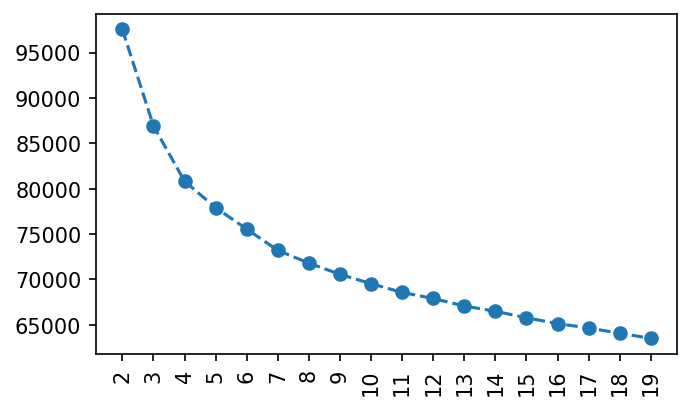

In [235]:
# plotting the result of SSD vs n-clusters

plt.figure(figsize = (5,3), dpi = 150)

plt.plot(range(2,20), sum_of_squared_distances, 'o--')

plt.xticks(ticks = range(2,20), rotation = 'vertical');

Based on the graph above, reasonable number of clusters would be 4 or 7. Visualizations will be created in order to fully comprehend the results of clustering based solely on the genetic composition of the cells.

### KMeans with 4 clusters

In [236]:
k_model_no_x_y_4 = KMeans(n_clusters = 4)

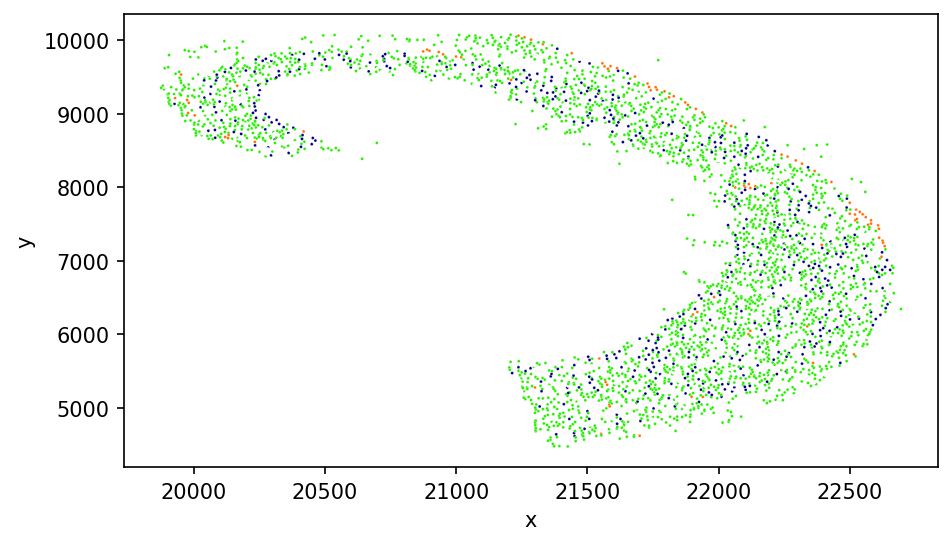

In [238]:
# The results of clustering using KMeans model with 4 clusters visualized

plt.figure(figsize = (7,4), dpi = 150)

graph = sns.scatterplot(final_df_with_50_genes['x'], final_df_with_50_genes['y'], hue = k_model_no_x_y_4.fit_predict(X_scaled), palette = 'gist_ncar', s = 2)

plt.legend([], [], frameon = False);

### KMeans with 7 clusters

In [239]:
k_model_no_x_y_7 = KMeans(n_clusters = 7)

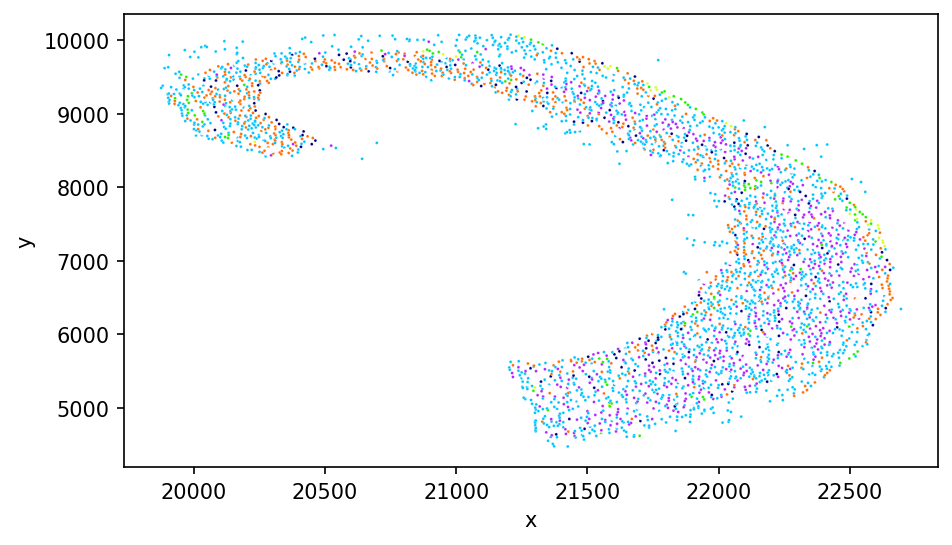

In [259]:
# The results of clustering using KMeans model with 7 clusters visualized

plt.figure(figsize = (7,4), dpi = 150)

graph = sns.scatterplot(final_df_with_50_genes['x'], final_df_with_50_genes['y'], hue = k_model_no_x_y_7.fit_predict(X_scaled), palette = 'gist_ncar', s = 2)

plt.legend([], [], frameon = False);

### DBSCAN Model

In [ ]:
X_scaled = scaler.fit_transform(df_with_no_x_y_25_genes)

Elbow method will be used to assess the performance of DBSCAN model with varying values of epsilon hyperparameter.

In [359]:
n_clusters = []
outlier_percent = []

for eps in np.linspace(0.01, 7, 30):
    db_model_no_x_y = DBSCAN(eps = eps)
    db_model_no_x_y.fit(X_scaled)
    
    n_clusters.append(len(pd.Series(db_model_no_x_y.labels_).unique()))
    outlier_percent.append(100*np.sum(db_model_no_x_y.labels_ == -1)/len(db_model_no_x_y.labels_))

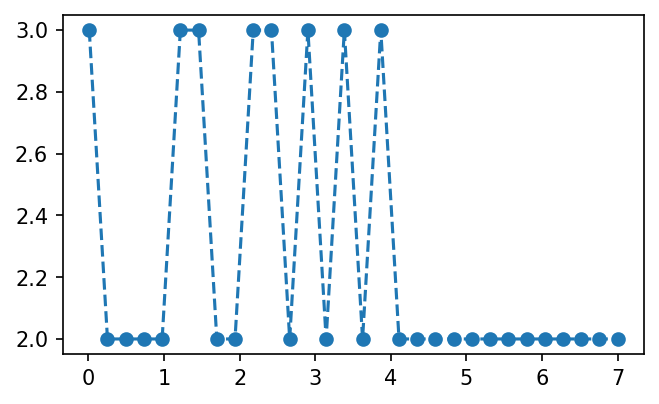

In [364]:
# plotting the result eps vs the number of clusters formed by DBSCAN

plt.figure(figsize = (5,3), dpi = 150)

plt.plot(np.linspace(0.01, 7, 30), n_clusters, 'o--');

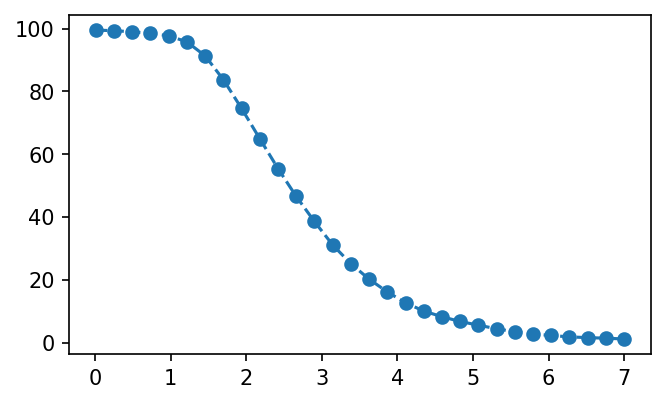

In [361]:
# plotting the result eps vs percentage of outliers formed by DBSCAN

plt.figure(figsize = (5,3), dpi = 150)

plt.plot(np.linspace(0.01, 7, 30), outlier_percent, 'o--');

In [296]:
db_model_no_x_y = DBSCAN(eps = 0.001)

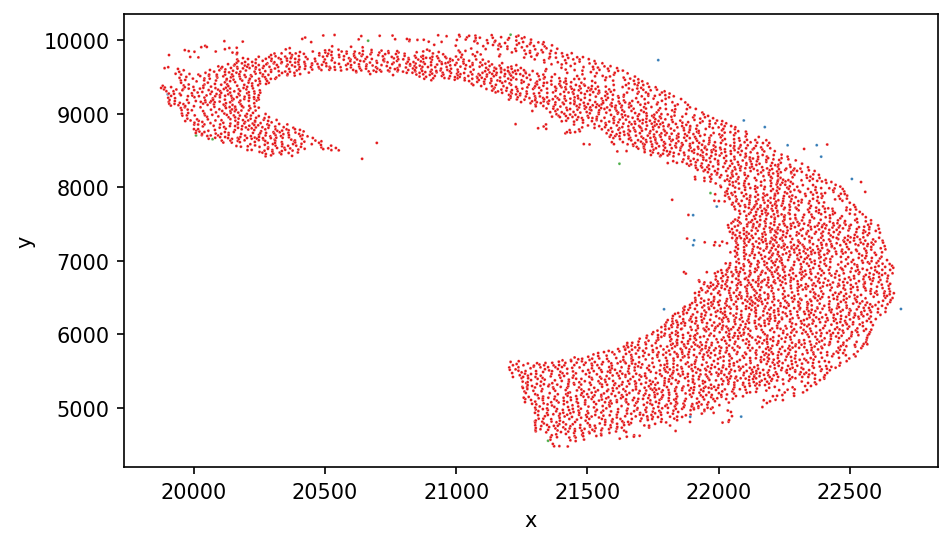

In [297]:
# The results of clustering using DBSCAN model with eps = 0.001 visualized

plt.figure(figsize = (7,4), dpi = 150)

graph = sns.scatterplot(final_df_with_50_genes['x'], final_df_with_50_genes['y'], hue = db_model_no_x_y.fit_predict(X_scaled), palette = 'Set1', s = 2)

plt.legend([], [], frameon = False);

It is clear that with variation of epsilon parameter DBSCAN fails to produce good results. Now will consider "min_samples" parameter in addition to epsilon parameter to try to improve the performance of DBSCAN algorithm. <br> 
Once again elbow method will be implemented in order to see the effect that the changes in "min_samples" will bring to the model.

In [298]:
# Elbow method is implemented to see how the variation in n_samples parameter effects the number of clusters found by the
# DBSCAN model

n_clusters = []

for samples in range(2, 30):
    db_model_no_x_y = DBSCAN(eps = 4, min_samples = samples)
    db_model_no_x_y.fit(X_scaled)
    
    n_clusters.append(len(pd.Series(db_model_no_x_y.labels_).unique()))

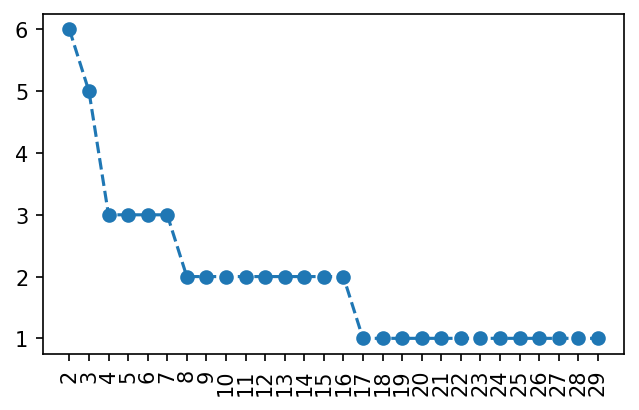

In [299]:
# plotting the result number of samples vs the number of clusters formed by DBSCAN

plt.figure(figsize = (5,3), dpi = 150)

plt.plot(range(2, 30), n_clusters, 'o--')

plt.xticks(ticks = range(2, 30), rotation = 'vertical');

It can be seen from the graph that parameter min_samples with eps = 0.01 does bring some new clusters into existance. Should now proceed to visualizing the result of clustering using DBSCAN with eps = 0.01, min_samples = 3

In [350]:
db_model_no_x_y = DBSCAN(eps = 4, min_samples = 3)

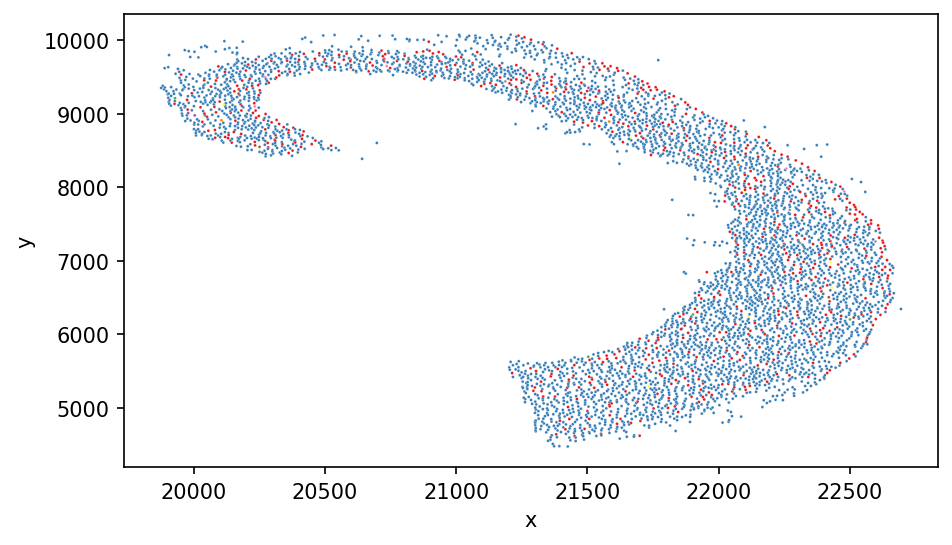

In [352]:
# The results of clustering using DBSCAN model with eps = 0.01 visualized

plt.figure(figsize = (7,4), dpi = 150)

graph = sns.scatterplot(final_df_with_50_genes['x'], final_df_with_50_genes['y'], hue = db_model_no_x_y.fit_predict(X_scaled), palette = 'Set1', s = 2)

plt.legend([], [], frameon = False);

#### Even when changing min_samples and eps parameters together, DBSCAN fails to produce good results. It may be due to the fact that data density being low.

# Running KMeans Clustering on 2 spatial coordinates and 25 "most abundant" gene features

In order to see how far can KMeans clustering algorithm take this clusterisation task "elbow" method was employed to determine a reasonable number of clusters for this feature set (containing 2 spatial coordinates and 25 "most abundant" genes. <br><br>

Elbow method will involve measuring sum of squared distances (SSD) from data points to their respective cluster centers. The rate of decrease of SSD will be considered as a tool to decide on the appropriate number of clusters for this feature set.

In [228]:
X_scaled = scaler.fit_transform(final_df_with_50_genes)

In [229]:
sum_of_squared_distances = []

for k in range(2,20):
    k_model = KMeans(n_clusters = k)
    k_model.fit(X_scaled)
    
    sum_of_squared_distances.append(k_model.inertia_)

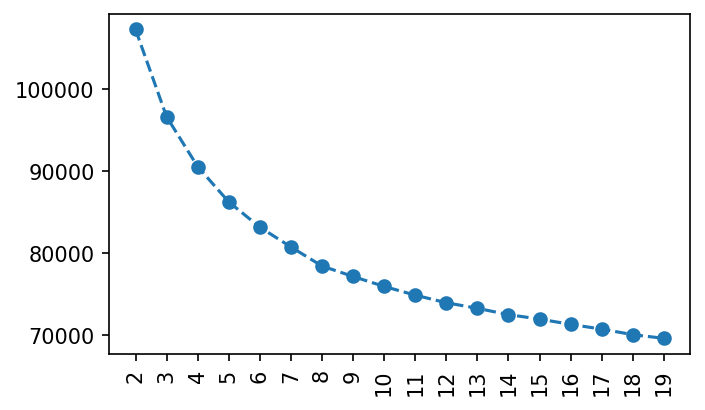

In [230]:
# plotting the result of SSD vs n-clusters

plt.figure(figsize = (5,3), dpi = 150)

plt.plot(range(2,20), sum_of_squared_distances, 'o--')

plt.xticks(ticks = range(2,20), rotation = 'vertical');

From the graph above it looks like k=5 or k=8 is a reasonable number of clusters. However, to improve the understanding of the graph above the differences between SSD between each consecutive k is presented below.

In [173]:
pd.Series(sum_of_squared_distances).diff().reindex(range(1,18))

1    -10639.1306
2     -6085.6887
3     -4302.6582
4     -3080.4777
5     -2413.3965
6     -2327.4364
7     -1266.3933
8     -1208.8649
9     -1070.6110
10     -943.1791
11     -728.1745
12     -646.9613
13     -582.1044
14     -559.8028
15     -703.0411
16     -414.6314
17     -644.9012
dtype: float64

Indeed, it does look like the 6'th decrease (corresponding to k = 8) is a reasonable place to stop KMeans on this feature set. <br> 

Now a KMeans model will be fitted with n_clusters = 5 and n_clusters = 8. Visualizations will be created to see what the clustering looks like in practice.

### KMeans with 5 clusters

In [203]:
# KMeans model with 5 clusters created

k_model_25_genes = KMeans(n_clusters = 5) 

In [204]:
# KMeans model with 5 clusters fitted

k_model_25_genes.fit(X_scaled)

KMeans(n_clusters=5)

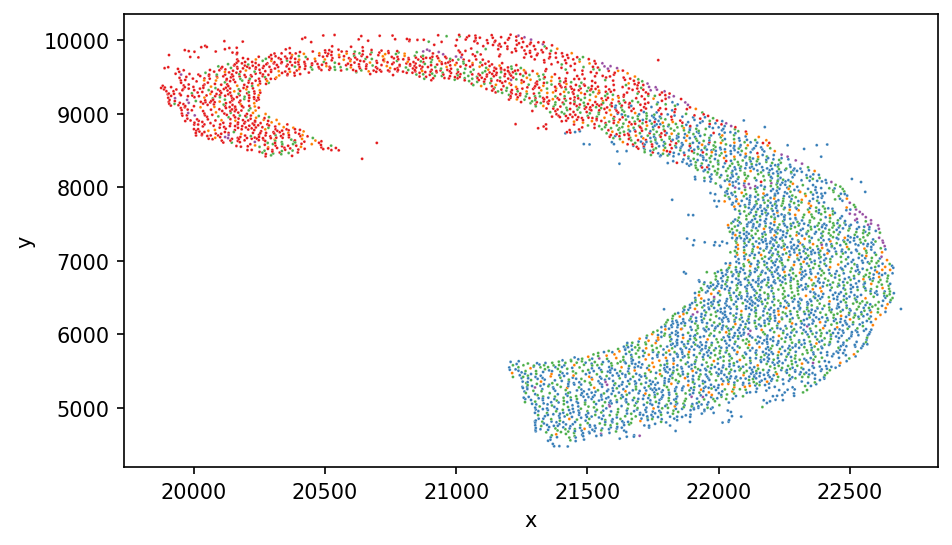

In [211]:
# The results of clustering using KMeans model with 5 clusters visualized

plt.figure(figsize = (7,4), dpi = 150)

graph = sns.scatterplot(final_df_with_50_genes['x'], final_df_with_50_genes['y'], hue = k_model_25_genes.fit_predict(X_scaled), palette = 'Set1', s = 2)

plt.legend([], [], frameon = False);

Clustering with KMeans algorithms and n_clusters = 5 shows some resemblance with the original illustration. <br> KMeans clearly found a boundrt at x ~ 21 500 where the midbrain is split into sections (red markers on the left | green and blue markers on the right). In addition, an outer section of the mid brain was partly picked up by the algorithm. Purple markers in the upper end of the mid brain might correspond to Ery and Fibro with regards to the original illustration provided by the company. 

### KMeans with 8 clusters

In [212]:
# KMeans model with 8 clusters created

k_model_25_genes_8_clusters = KMeans(n_clusters = 8) 

In [213]:
# KMeans model with 8 clusters fitted

k_model_25_genes_8_clusters.fit(X_scaled)

KMeans()

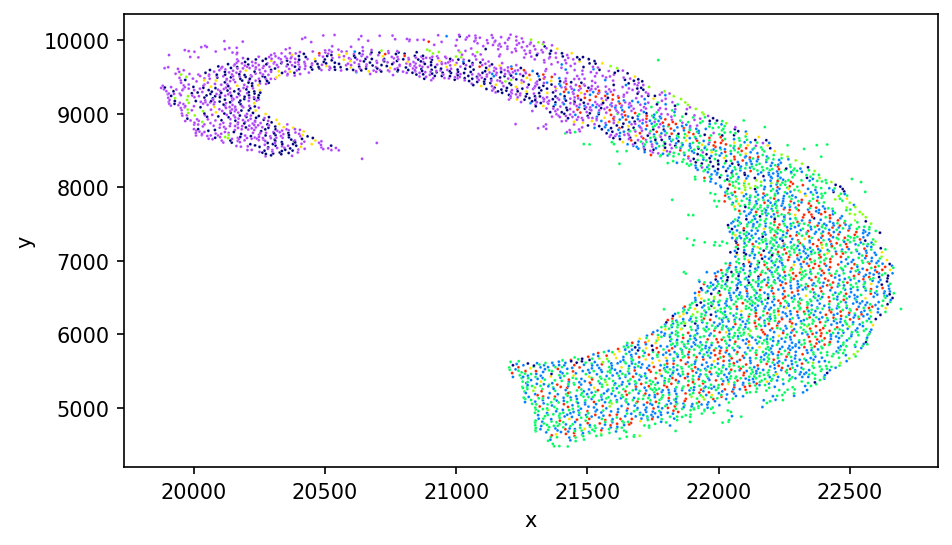

In [220]:
# The results of clustering using KMeans model with 8 clusters visualized

plt.figure(figsize = (7,4), dpi = 150)

graph = sns.scatterplot(final_df_with_50_genes['x'], final_df_with_50_genes['y'], hue = k_model_25_genes_8_clusters.fit_predict(X_scaled), palette = 'gist_ncar', s = 2)

plt.legend([], [], frameon = False);

Using KMeans algorithm with 8 clusters gives similar results to using KMeans algorithm with 5 clusters. Using 8 clusters did not provide any significant improvements to the clustering ability of the algorithm.

# DBSCAN on 2 spatial coordinates and 25 genes

In [377]:
X_scaled = scaler.fit_transform(final_df_with_50_genes)

In [381]:
# Due to similarities between this data set (containing 25 gene based features and 2 spatial coordinates) with the data set
# containing just 25 gene based features some reasonable values are picked for eps and min_samples based on previous analysis

db_model = DBSCAN(min_samples = 2, eps = 4.5)

In [382]:
db_model.fit(X_scaled)

DBSCAN(eps=4.5, min_samples=2)

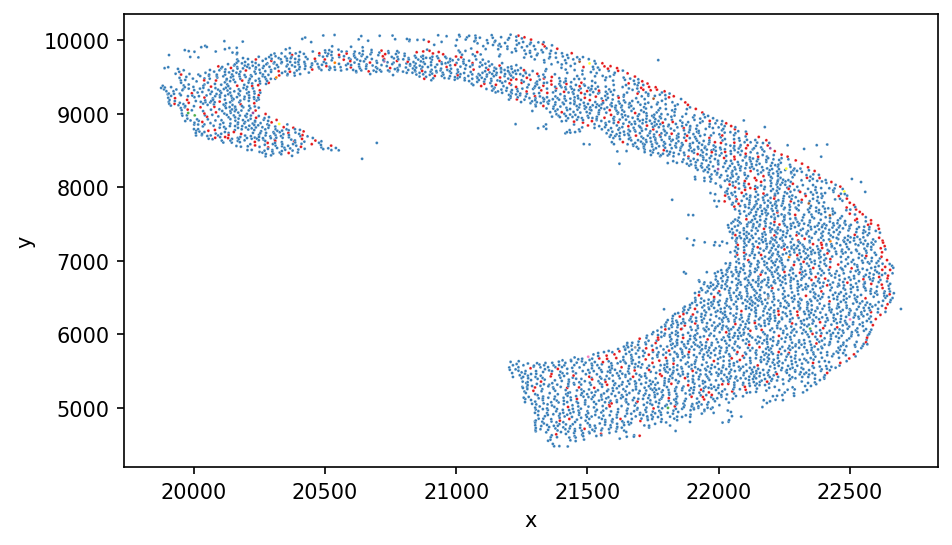

In [383]:
# The results of clustering using DBSCAN model with eps = 0.01 visualized

plt.figure(figsize = (7,4), dpi = 150)

graph = sns.scatterplot(final_df_with_50_genes['x'], final_df_with_50_genes['y'], hue = db_model.fit_predict(X_scaled), palette = 'Set1', s = 2)

plt.legend([], [], frameon = False);

DBSCAN did not produce any valuable results.

# DBSCAN algorithm fails to produce good results on all data sets. From this point only KMeans algorithm will be considered.

In the prevvious sections it was discovered that KMeans algorithm outperforms DBSCAN on the given data set. <br> 
Moreover, it was discovered that due to the nature of KMeans 2 features that correspond to spatial coordinates have a drastic effect on clustering results. <br> 
Two plots will be demostrated below showing the results of KMeans algorithm on two datasets:
   1. Data set that contains two spatial coordinates and 25 features associated with most abundant genes in the mid brain.
   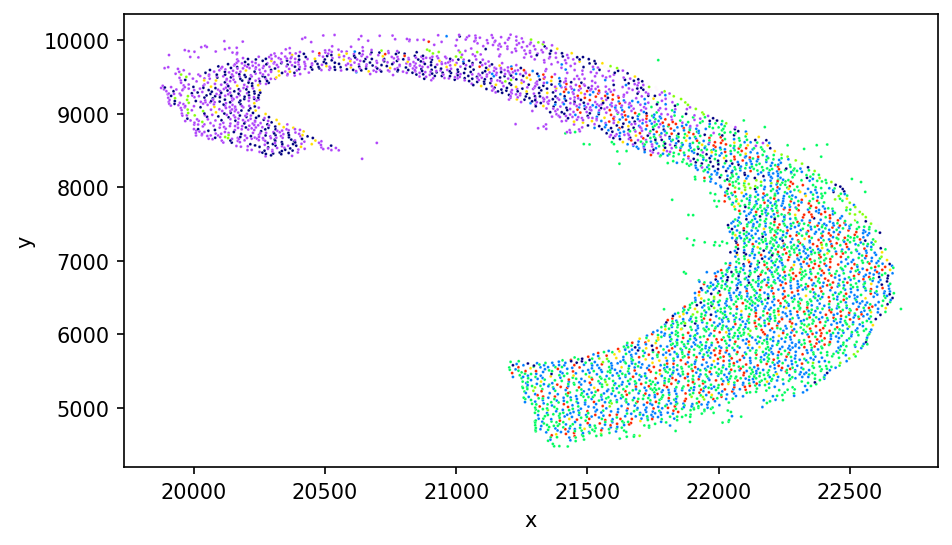
   
A clear separation is visible at x ~ 21 500. This separation is the result of the presence of two spatial features (x and y coordinates of the cell). Overall, the result of clustering is strongly distored by the presence of these two features.

   2. Data set that contains only 25 features associated with the most abundant genes in the mid brain.
   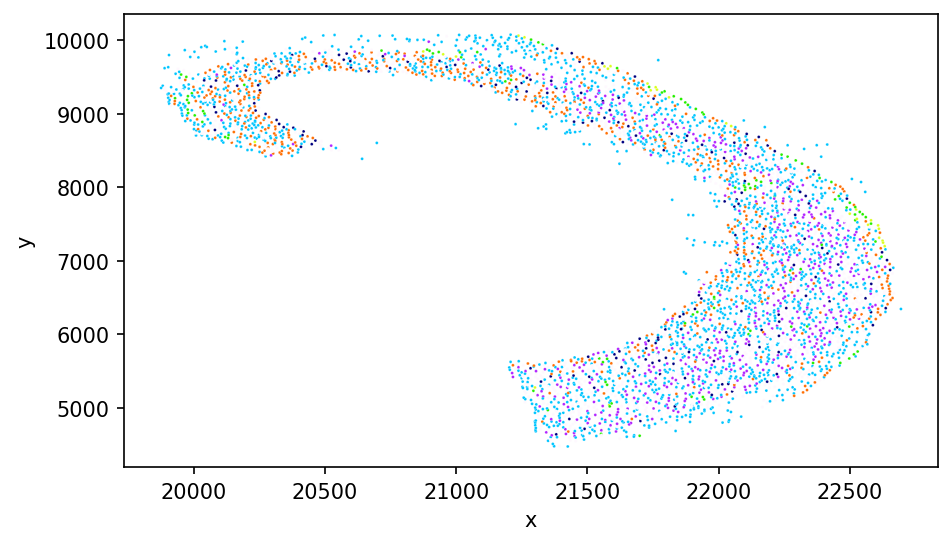

Using the data set that contains 25 most abundant genes proved to be fruitful. Some patterns presented in the original publications can already be recognised (with only 25 gene features!). <br>

However, in order to improve on this result more features that are based on the genetic composition of the cell will be added. 

# A new data set is formed that will contain every feature based on genetic composition of a cell

In [386]:
# Creating columns for a new data frame
columns_for_full_gene_df = ['x', 'y']


for i in df['geneID'].unique():
    columns_for_full_gene_df.append(i)

In [388]:
# defining a new data frame that will contain all features associated with cell genetic configuration

df_with_all_genes = pd.DataFrame(index = df['cell'].unique(), columns = columns_for_full_gene_df)

In [389]:
df_with_all_genes.head()

x    y Arpc1b B230118H07Rik Bcl2l12 Ccnd3 Cdk8 Commd4 Cops9 Creg1  \
170675  NaN  NaN    NaN           NaN     NaN   NaN  NaN    NaN   NaN   NaN   
170785  NaN  NaN    NaN           NaN     NaN   NaN  NaN    NaN   NaN   NaN   
170808  NaN  NaN    NaN           NaN     NaN   NaN  NaN    NaN   NaN   NaN   
170818  NaN  NaN    NaN           NaN     NaN   NaN  NaN    NaN   NaN   NaN   
170819  NaN  NaN    NaN           NaN     NaN   NaN  NaN    NaN   NaN   NaN   

       Dhx36 Emc7 Emg1 Fam111a Fbrs Fbxl12 Ftl1 Fundc2 Galnt10  Gls Gm10076  \
170675   NaN  NaN  NaN     NaN  NaN    NaN  NaN    NaN     NaN  NaN     NaN   
170785   NaN  NaN  NaN     NaN  NaN    NaN  NaN    NaN     NaN  NaN     NaN   
170808   NaN  NaN  NaN     NaN  NaN    NaN  NaN    NaN     NaN  NaN     NaN   
170818   NaN  NaN  NaN     NaN  NaN    NaN  NaN    NaN     NaN  NaN     NaN   
170819   NaN  NaN  NaN     NaN  NaN    NaN  NaN    NaN     NaN  NaN     NaN   

       Gm15976 Gm2000 Gm20425 Gm42418 Gpx7 H1f0 H2afv H2afy Hba-x Hbb-bt  \
170675     NaN    NaN     NaN     NaN  NaN  NaN   NaN   NaN   NaN    NaN   
170785     NaN    NaN     NaN     NaN  NaN  NaN   NaN   NaN   NaN    NaN   
170808     NaN    NaN     NaN     NaN  NaN  NaN   NaN   NaN   NaN    NaN   
170818     NaN    NaN     NaN     NaN  NaN  NaN   NaN   NaN   NaN    NaN   
170819     NaN    NaN     NaN     NaN  NaN  NaN   NaN   NaN   NaN    NaN   

       Higd2a Hnrnpab Igf1r Jarid2 Kars Klf2 Lgals1 Mcm7 Med10 Mrps26  Msn  \
170675    NaN     NaN   NaN    NaN  NaN  NaN    NaN  NaN   NaN    NaN  NaN   
170785    NaN     NaN   NaN    NaN  NaN  NaN    NaN  NaN   NaN    NaN  NaN   
170808    NaN     NaN   NaN    NaN  NaN  NaN    NaN  NaN   NaN    NaN  NaN   
170818    NaN     NaN   NaN    NaN  NaN  NaN    NaN  NaN   NaN    NaN  NaN   
170819    NaN     NaN   NaN    NaN  NaN  NaN    NaN  NaN   NaN    NaN  NaN   

       Myh9 Naaladl2 Ndufa13 Ndufa3 Nr2c2ap Ntan1 Oard1 Paf1 Pebp1 Pigp  \
170675  NaN      NaN     NaN    NaN     NaN   NaN   NaN  NaN   NaN  NaN   
170785  NaN      NaN     NaN    NaN     NaN   NaN   NaN  NaN   NaN  NaN   
170808  NaN      NaN     NaN    NaN     NaN   NaN   NaN  NaN   NaN  NaN   
170818  NaN      NaN     NaN    NaN     NaN   NaN   NaN  NaN   NaN  NaN   
170819  NaN      NaN     NaN    NaN     NaN   NaN   NaN  NaN   NaN  NaN   

       Pitpnm2 Pitrm1  Pkm Ppia Prkaa1 Psmc3  Ptn Rapgef4 Rpl11 Rpl27a Rpl4  \
170675     NaN    NaN  NaN  NaN    NaN   NaN  NaN     NaN   NaN    NaN  NaN   
170785     NaN    NaN  NaN  NaN    NaN   NaN  NaN     NaN   NaN    NaN  NaN   
170808     NaN    NaN  NaN  NaN    NaN   NaN  NaN     NaN   NaN    NaN  NaN   
170818     NaN    NaN  NaN  NaN    NaN   NaN  NaN     NaN   NaN    NaN  NaN   
170819     NaN    NaN  NaN  NaN    NaN   NaN  NaN     NaN   NaN    NaN  NaN   

       Rpl41 Rps15 Rps26 Rps3a1 Rps6 Selenop Serpinf1 Sfrp1 Slc25a17 Smarcal1  \
170675   NaN   NaN   NaN    NaN  NaN     NaN      NaN   NaN      NaN      NaN   
170785   NaN   NaN   NaN    NaN  NaN     NaN      NaN   NaN      NaN      NaN   
170808   NaN   NaN   NaN    NaN  NaN     NaN      NaN   NaN      NaN      NaN   
170818   NaN   NaN   NaN    NaN  NaN     NaN      NaN   NaN      NaN      NaN   
170819   NaN   NaN   NaN    NaN  NaN     NaN      NaN   NaN      NaN      NaN   

       Smim26 Snrnp48 Snrpd1 Spry3 Stk38 Stk38l Stx4a Syngr2  Tfg Tpm2 Tprgl  \
170675    NaN     NaN    NaN   NaN   NaN    NaN   NaN    NaN  NaN  NaN   NaN   
170785    NaN     NaN    NaN   NaN   NaN    NaN   NaN    NaN  NaN  NaN   NaN   
170808    NaN     NaN    NaN   NaN   NaN    NaN   NaN    NaN  NaN  NaN   NaN   
170818    NaN     NaN    NaN   NaN   NaN    NaN   NaN    NaN  NaN  NaN   NaN   
170819    NaN     NaN    NaN   NaN   NaN    NaN   NaN    NaN  NaN  NaN   NaN   

       Trmt6 Trp53bp1 Tubb5 Tubgcp4 Uba52  Ubb Ube2l3 Wdr83os Zfp27 Zfp574  \
170675   NaN      NaN   NaN     NaN   NaN  NaN    NaN     NaN   NaN    NaN   
170785   NaN      NaN   NaN     NaN   NaN  NaN    NaN     NaN   NaN    NaN   
170808

In [390]:
# filling in the feature values using MIDCounts column from the original data frame

for i in tqdm_notebook(df_with_all_genes.index):
    d = df[df['cell'] == i][['geneID', 'MIDCounts']].T.to_dict()
    for j in d.keys():
        df_with_all_genes[d[j]['geneID']].loc[i] = d[j]['MIDCounts']


In [392]:
df_with_all_genes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4872 entries, 170675 to 181844
Columns: 18700 entries, x to Far2os1
dtypes: object(18700)
memory usage: 695.2+ MB


Using all these features is not only unreasonable, but also extremely computationally heave. Therefore, the feature number will be cut down based on the amount of empty cells present in each feature.

In [395]:
# First the spatial coordinates features are filled with values 

df_with_all_genes['x'] = final_df['x']
df_with_all_genes['y'] = final_df['y']

In [401]:
# Percentage of empty cells in each feature is displayed

empty_feat_list = df_with_all_genes.isnull().sum().sort_values(ascending = True)/len(df_with_all_genes)*100

Different number of features will be considered in order to build the most precise model

# Building a model with a data set that contains only features that were missing less than 50% of entries

In [414]:
# First try only using features where < 50 of values are missing

empty_feat_list.reset_index()[empty_feat_list.reset_index()[0] < 50]['index'].tolist()

['x',
 'y',
 'Gm42418',
 'Cdk8',
 'Tmsb4x',
 'Rpl41',
 'Hbb-bs',
 'Gphn',
 'Cmss1',
 'Lars2',
 'Ftl1',
 'Tuba1a',
 'Actb',
 'Rps14',
 'Rplp0',
 'Rplp1',
 'Rpl37a',
 'Rps26',
 'Gm26917',
 'Hba-a1',
 'Rps5',
 'Rps8',
 'Tubb5',
 'Rps19',
 'Malat1',
 'Tmsb10',
 'Rpl37',
 'Hsp90ab1',
 'Hbb-bt',
 'Rpl13a',
 'Rps27',
 'Rps24',
 'Hba-a2',
 'Rps9',
 'Eef1a1',
 'Stmn1',
 'Ubb',
 'Rps17',
 'Rps18',
 'Rpl18a',
 'Rpl26',
 'Fau',
 'Rpl14',
 'Jarid2']

In [459]:
df_less_50_miss = df_with_all_genes[empty_feat_list.reset_index()[empty_feat_list.reset_index()[0] < 50]['index'].tolist()]

In [460]:
df_less_50_miss = df_less_50_miss.fillna(0)

## KMeans
In order to see how far can KMeans clustering algorithm take this clusterisation task "elbow" method was employed to determine a reasonable number of clusters for this feature set. <br><br>

Elbow method will involve measuring sum of squared distances (SSD) from data points to their respective cluster centers. The rate of decrease of SSD will be considered as a tool to decide on the appropriate number of clusters for this feature set.

In [574]:
# Applying StandardScaler to the data

X_scaled = scaler.fit_transform(df_less_50_miss)

In [462]:
# Employing Elbow Method

sum_of_squared_distances = []

for k in range(2,30):
    model = KMeans(n_clusters = k)
    model.fit(X_scaled)
    
    sum_of_squared_distances.append(model.inertia_)

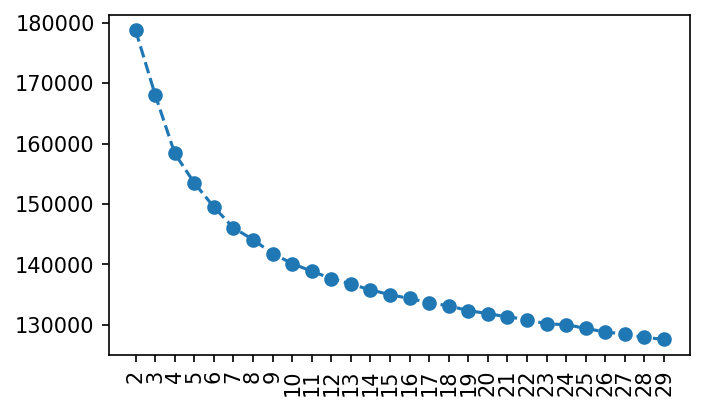

In [463]:
# Visualizing the results of elbow method

plt.figure(figsize = (5,3), dpi = 150)

plt.plot(range(2,30), sum_of_squared_distances, 'o--')

plt.xticks(ticks = range(2,30), rotation = 'vertical');

From the graph it is likely that 5, 7, or 9 clusters would suit this data

In [484]:
pd.Series(sum_of_squared_distances).diff().reindex(range(1,20))

1    -10656.9544
2     -9693.2311
3     -4882.0379
4     -3979.4136
5     -3440.5756
6     -1954.1340
7     -2298.3881
8     -1649.4243
9     -1281.4530
10    -1197.5145
11     -918.5388
12     -959.3053
13     -801.5855
14     -622.0579
15     -698.1746
16     -532.1691
17     -770.6197
18     -511.7694
19     -530.4116
dtype: float64

### KMeans 5 Clusters - Results and Visualization

In [475]:
model = KMeans(n_clusters = 5)

In [476]:
model.fit(df_less_50_miss)

KMeans(n_clusters=5)

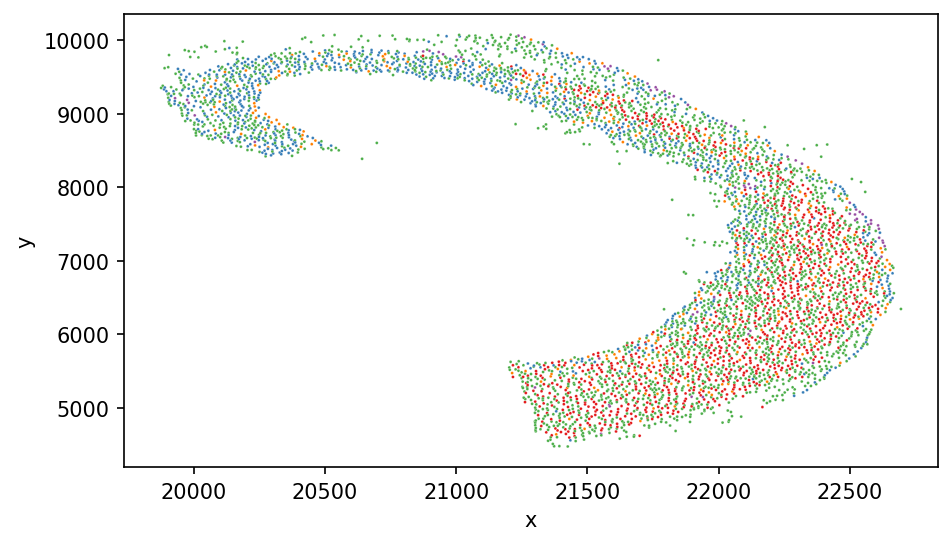

In [479]:
# The results of clustering using KMeans model with 5 clusters visualized

plt.figure(figsize = (7,4), dpi = 150)

graph = sns.scatterplot(final_df_with_50_genes['x'], final_df_with_50_genes['y'], hue = model.fit_predict(X_scaled), palette = 'Set1', s = 2)

plt.legend([], [], frameon = False);

### KMeans 7 clusters - Results and Visualization

In [485]:
model = KMeans(n_clusters = 7)

In [486]:
model.fit(df_less_50_miss)

KMeans(n_clusters=7)

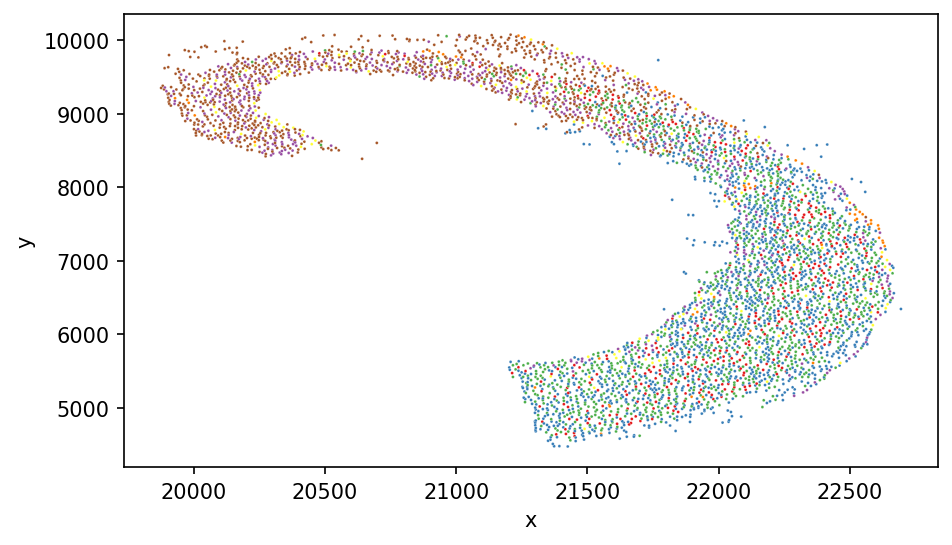

In [489]:
# The results of clustering using KMeans model with 7 clusters visualized

plt.figure(figsize = (7,4), dpi = 150)

graph = sns.scatterplot(final_df_with_50_genes['x'], final_df_with_50_genes['y'], hue = model.fit_predict(X_scaled), palette = 'Set1', s = 2)

plt.legend([], [], frameon = False);

### KMeans 9 clusters - Results and Visualization

In [490]:
model = KMeans(n_clusters = 9)

In [491]:
model.fit(df_less_50_miss)

KMeans(n_clusters=9)

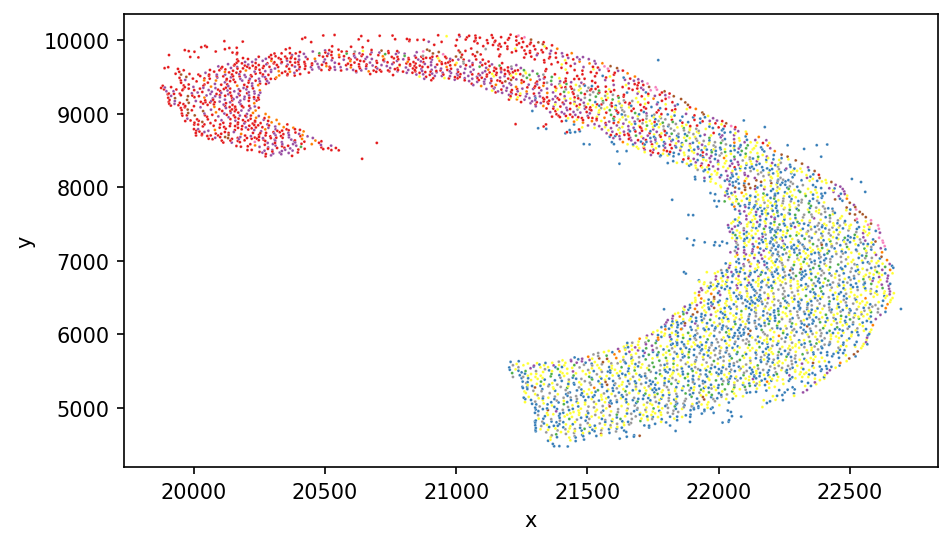

In [496]:
# The results of clustering using KMeans model with 9 clusters visualized

plt.figure(figsize = (7,4), dpi = 150)

graph = sns.scatterplot(final_df_with_50_genes['x'], final_df_with_50_genes['y'], hue = model.fit_predict(X_scaled), palette = 'Set1', s = 2)

plt.legend([], [], frameon = False);

KMeans Clustering showed significant improvements in its ability to resolve clusters of cells when new features were introduced. It is especially evident in KModel with 9 clusters, where most parts of the mid brain shown in the original publication are visible. <br>

There are two ways to improve the current performance of the clustering algorithm:
   1. Possibly add more features to include more information from the original data set
   2. Use different suitable clusterisation algorithm. Then join it together with KMeans to form an ensemble model.

# OPTICS algorithm 

In [497]:
from sklearn.cluster import OPTICS

In [507]:
optics_model = OPTICS(min_samples=3, metric = 'euclidean')

In [508]:
optics_model.fit_predict(X_scaled)

array([-1,  0, -1, ..., -1, -1, -1])

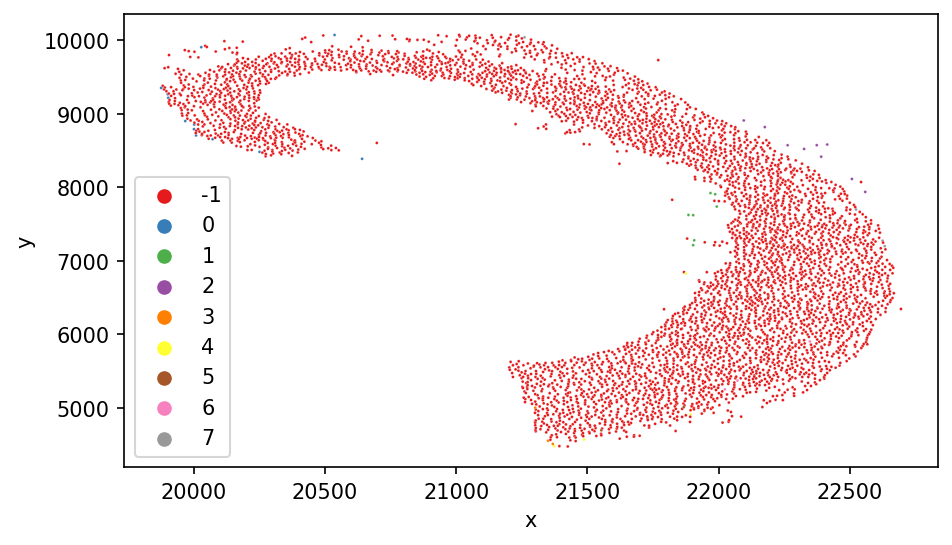

In [509]:
plt.figure(figsize = (7,4), dpi = 150)

graph = sns.scatterplot(final_df_with_50_genes['x'], final_df_with_50_genes['y'], hue = optics_model.fit_predict(X_scaled), palette = 'Set1', s = 2)

#plt.legend([], [], frameon = False);

OPTICS encounters a similar problem to DBSCAN. Low density of the data provided is a major obstacle to a good performance of the algorithm.

# Hierarchical Clustering

### Model performance on reasonable parameters

In [510]:
# Importing the model

from sklearn.cluster import AgglomerativeClustering

In [566]:
# Model trial with reasonable number of clusters

agglo_model = AgglomerativeClustering(n_clusters = 8)

For Hierarchical clustering model, MinMaxScaler is better than StandardScaler. Therefore, in this section data is scaled using MixMaxScaler

In [567]:
from sklearn.preprocessing import MinMaxScaler

In [568]:
min_max_scaler = MinMaxScaler()

In [569]:
X_scaled_min_max = min_max_scaler.fit_transform(df_less_50_miss)

In [570]:
# Fitting the model

agglo_model.fit(X_scaled_min_max)

AgglomerativeClustering(n_clusters=8)

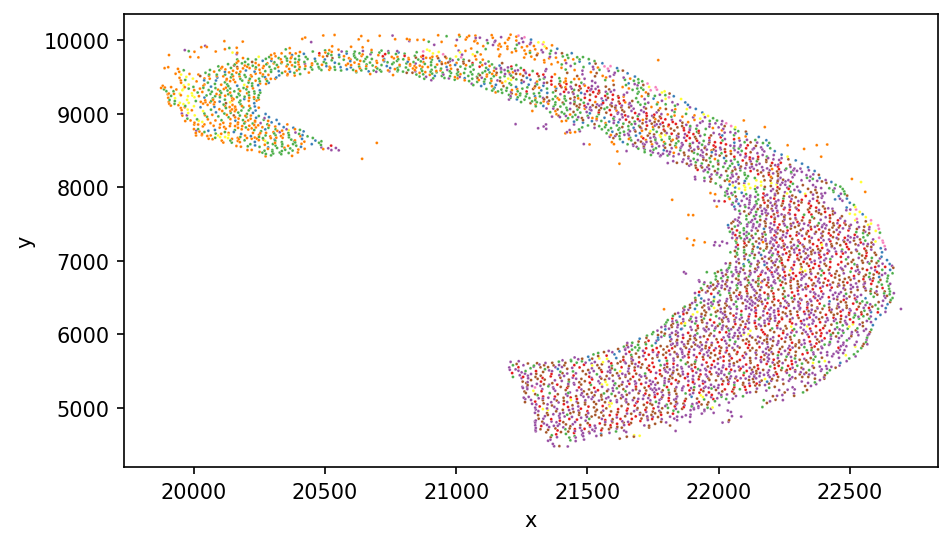

In [571]:
#Plotting the results of the model

plt.figure(figsize = (7,4), dpi = 150)

graph = sns.scatterplot(final_df_with_50_genes['x'], final_df_with_50_genes['y'], hue = agglo_model.fit_predict(X_scaled), palette = 'Set1', s = 2)

plt.legend([], [], frameon = False);

The hierarchical model is performing well on reasonable values. Therefore, it is desirable to tune it to make as good a job as it possibly can. The tuning is left out of the scope of the notebook in order not to pollute it even more. <br>
Nevertheless, the optimal value for clustering using Hierarchical algorithm is 8,9, or 10.

## Several other clustering algorithms were used. They did not give good results and are left off the scope of the notebook to make it shorter.

# Unsupervised Ensemble Model Consisting of one KMeans and one Hierarchical Clustering models

In [581]:
k_means_model_9_clusters = KMeans(n_clusters = 9)

In [583]:
KMEANS = k_means_model_9_clusters.fit_predict(X_scaled)

In [584]:
aggl_model_9_clusters = AgglomerativeClustering(n_clusters = 9)

In [586]:
AGGL = aggl_model_9_clusters.fit_predict(X_scaled_min_max)

In [601]:
data = {'KMEANS': KMEANS.tolist(), 'AGGL' : AGGL.tolist()}

In [611]:
ensemble_data_set = pd.DataFrame(data=data)

In [613]:
ensemble_data_set.head()

KMEANS  AGGL
0       0     3
1       0     3
2       0     3
3       0     3
4       0     3

In [616]:
# Now run a final KMEANS model on top of that

final_k_means = KMeans(n_clusters= 9)

In [617]:
final_scale = scaler.fit_transform(ensemble_data_set)

In [618]:
final_k_means.fit(ensemble_data_set)

KMeans(n_clusters=9)

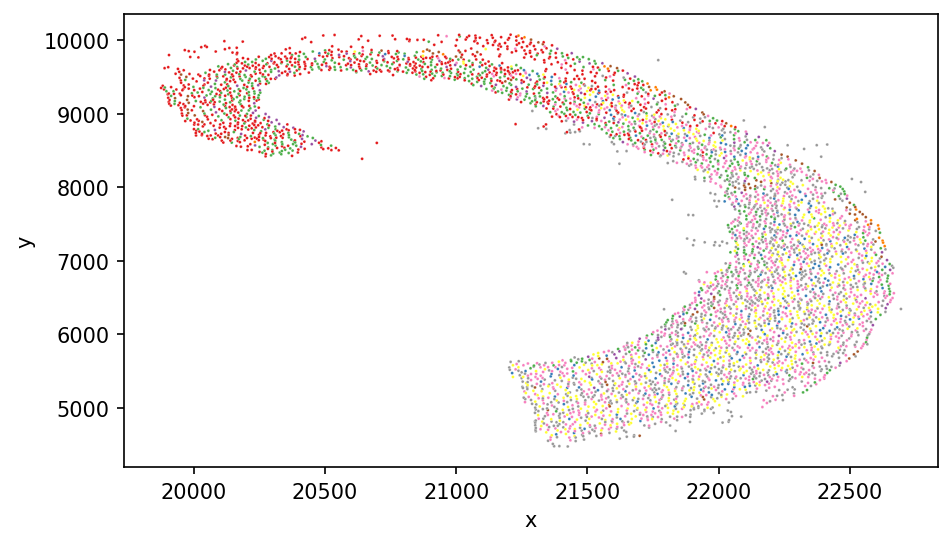

In [644]:
#Plotting the results of the model

plt.figure(figsize = (7,4), dpi = 150)

graph = sns.scatterplot(final_df_with_50_genes['x'], final_df_with_50_genes['y'], hue = final_k_means.fit_predict(X_scaled), palette = 'Set1', s = 2)

plt.legend([], [], frameon = False);

This is the result of running KMeans with 9 clusters on ensemble of results from Kmeans and Hierarchical clustering models. 